### Pytorch - classifier
- CNN을 활용한 모델을 만들어서 CIFAR-10에 대하여 정확도 95% 이상의 Classifier를 만드세요
- 예제 코드는 MNIST에 대한 코드

In [22]:
from matplotlib import pyplot as plt
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader

torch.manual_seed(0) # seed 고정 - 여러번 실행해도 같은 결과가 나오도록 설정

#### Dataset download

In [23]:
# CIFAR10
train_data = datasets.CIFAR10(
    root = 'data',
    train = True,                         
    transform = ToTensor(), 
    download = True,            
)
dataloader_train = DataLoader(train_data, 
                              batch_size=256, 
                              shuffle=True)

test_data = datasets.CIFAR10(
    root = 'data', 
    train = False, 
    transform = ToTensor()
)
dataloader_test = DataLoader(test_data, 
                              batch_size=256, 
                              shuffle=True)

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified


#### Check images

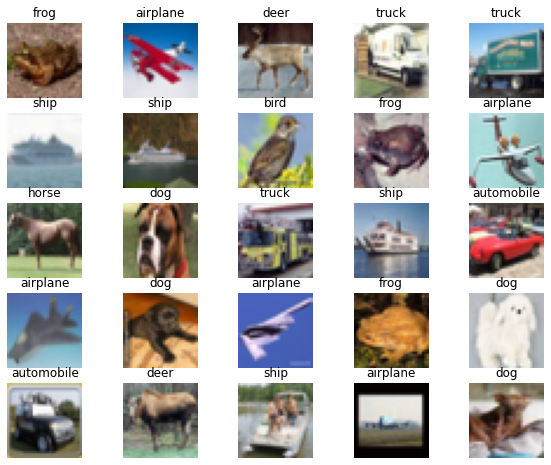

Data shape: torch.Size([3, 32, 32])


In [24]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(class_names[label])
    plt.axis("off")
    plt.imshow(img.permute(1, 2, 0))
plt.show()
print('Data shape:', img.shape)


#### ResNet

In [25]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4), 
                                        nn.Flatten(), 
                                        nn.Linear(512, num_classes))
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

#### Train

In [26]:
resnet = ResNet(3,10)
loss_func = nn.CrossEntropyLoss()   
optimizer = optim.Adam(resnet.parameters(), lr = 0.01)   

In [27]:
# Train the model
num_epochs = 10

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(dataloader_train):
        output = resnet(images)           
        loss = loss_func(output, labels)

        # clear gradients for this training step   
        optimizer.zero_grad()           

        # backpropagation, compute gradients 
        loss.backward()    
        # apply gradients             
        optimizer.step()                

        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}], Loss: {:.4f}' 
                   .format(epoch + 1, num_epochs, i + 1, loss.item()))

Epoch [1/10], Step [100], Loss: 1.7741
Epoch [2/10], Step [100], Loss: 1.0442
Epoch [3/10], Step [100], Loss: 0.8157
Epoch [4/10], Step [100], Loss: 0.6062
Epoch [5/10], Step [100], Loss: 0.3453
Epoch [6/10], Step [100], Loss: 0.2376
Epoch [7/10], Step [100], Loss: 0.1766
Epoch [8/10], Step [100], Loss: 0.1278
Epoch [9/10], Step [100], Loss: 0.0880
Epoch [10/10], Step [100], Loss: 0.0836


#### Test

In [28]:
resnet.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in dataloader_test:
        test_output = resnet(images)
        pred_y = torch.max(test_output, 1)[1].data.squeeze() # max 를 통해 가장 확률이 높은 숫자를 선택
        correct += (pred_y == labels).sum().item() # 가장 확률이 높은 숫자인 pred_y와 label이 같으면 정답 - 정답인 개수 확인
        total += labels.size(0) 
    accuracy = correct / total * 100
    
print('Test Accuracy of the model on the 10000 test images: %.2f Percent' % accuracy)

Test Accuracy of the model on the 10000 test images: 81.13 Percent
